# Python Package for USDA-ARS SCINet GeoCDL

## Overview
This tutorial covers the python package `pygcdl` for the SCINet Geospatial Common 
Data Library (GeoCDL), a community project from the 
[Geospatial Research Working Group](https://scinet.usda.gov/working-groups/geospatial) 
to reduce the time and effort to access commonly used geospatial datasets. This 
tutorial is based on the vignette for the R counterpart of pygcdl, rgeocdl. We have
collected several large gridded data products to store on Ceres and created a 
REST API for SCINet users to request the spatiotemporal subsets of those data 
that they need. The geospatial processing to create those subsets executes on 
Ceres and a service node has been setup to serve the API. 

This python package is a user-friendly interface to pass along user requests to the 
core GeoCDL API from the compute nodes. That is, the python package does not perform 
the geospatial processing itself. A major benefit of using this python package is that 
it was designed to integrate into a user's geospatial data processing workflow in 
Python. For example, a user storing their study area boundary definition as a 
`geopandas.GeoDataFrame` object can pass along that object to this package's 
functions and the package will do the necessary formatting of the data to make it 
compatible with GeoCDL. 

The workflows we will cover include uploading a GeoJSON of an LTAR site, 
requesting data from two datasets clipped to the boundary of the LTAR site 
with equivalent resolutions and CRSs, and visualizing the resulting 
maps. We also show how to extract point level information from a gridded layer.

This tutorial assumes you are running this notebook in JupyterLab on 
Ceres. The easiest way to do that is with 
[Open OnDemand](http://ceres-ood.scinet.usda.gov/). As of this writing, the GeoCDL 
is only available on Ceres and not Atlas. 

If you have any questions, problems, or requests related to the python interface, please 
use the issue tracker on our GitHub repository: 
[https://github.com/USDA-SCINet/pygcdl](https://github.com/USDA-SCINet/pygcdl). 

## Nomenclature

* <b>GeoCDL:</b> Geospatial Common Data Library, a collection of commonly used raster 
  datasets accessible from an API running on SCINet's Ceres cluster
* <b>Raster:</b> A geospatial datatype where data is stored as a grid of regularly sized pixels. Geospatial rasters contain geospatial metadata, which maps each pixel of the raster to a geospatial location on the Earth's surface. Examples of geospatial raster file types include: geotiff (.tif), and netCDF (.nc).
* <b>Vector:</b> A geospatial datatype where data is stored as a collection of points, lines, or polygons. Each coordinate maps to a location on Earth's surface. Examples of geospatial vector file types include: geojson (.geojson), and shapefiles (.shp). 
* <b>CRS:</b> Coordinate Reference System, also known as a spatial reference system. A
  system for defining geospatial coordinates.

## Data Details

###### Dataset: MODIS NDVI
* Link: [https://doi.org/10.3334/ORNLDAAC/1299](https://doi.org/10.3334/ORNLDAAC/1299)
* Details: This data set provides Moderate Resolution Imaging Spectroradiometer 
  (MODIS) normalized difference vegetation index (NDVI) data, smoothed and gap-filled, 
  for the conterminous US for the period 2000-01-01 through 2015-12-31. The data 
  were generated using the NASA Stennis Time Series Product Tool (TSPT) to generate 
  NDVI data streams from the Terra satellite (MODIS MOD13Q1 product) and Aqua 
  satellite (MODIS MYD13Q1 product) instruments. TSPT produces NDVI data that 
  are less affected by clouds and bad pixels.

###### Dataset: PRISM
* Link: [https://prism.oregonstate.edu/](https://prism.oregonstate.edu/)
* Details: The PRISM Climate Group gathers climate observations from a 
  wide range of monitoring networks, applies sophisticated quality control 
  measures, and develops spatial climate datasets to reveal short- and long-term 
  climate patterns. The resulting datasets incorporate a variety of modeling 
  techniques and are available at multiple spatial/temporal resolutions, covering 
  the period from 1895 to the present.


## Primary Libraries

| Name | Description | Link |
|:--|:--|:--|
| pygcdl | Python interface for SCINet GeoCDL API | https://github.com/USDA-SCINet/pygcdl |
| geopandas | Geospatial vector data for python | https://geopandas.org/en/stable/ |
| rioxarray | Geospatial raster data for python | https://corteva.github.io/rioxarray/stable/ |


### Tutorial Steps:
0. Import Libraries
1. Specify area and dates of interest 
2. Select datasets and their variables
3. Download the data
4. Visualize the results


## Part 0: Import Libraries

First, we need to create the jupyter kernel. Open up a terminal prompt, navigate to the `pygcdl/` directory, and run the following commands:

`source pygcdl_env/bin/activate` </br>
`module load python` </br>
`ipython kernel install --name "pygcdl_env" --user` </br>

Then, set your jupyter notebook kernel to `pygcdl_env`. Note that it will take a minute to show up as an option after running the `ipython` command.

In [1]:
# Import the necessary packages.
import pygcdl
import geopandas as gpd
import pandas as pd
import numpy as np
from pathlib import Path
import requests as r
import rioxarray
import xarray as xr
import matplotlib.pyplot as plt
import math

In [2]:
# Create the pygcdl object in order to interact with the pygcdl package.
pygcdl_obj = pygcdl.PyGeoCDL(url_base="http://127.0.0.1:8000")

## Part 1: Specify area and dates of interest 

Here, we specify the spatial extent of our requests. We can request either polygon-based or point-based subsets. When we request a subset, we can specify the spatial extent in one of these three ways:

- <b>GUID: </b> Users can use the `upload_geometry()` function to upload a file or `geopandas` GeoDataFrame object, receive a Geometry Upload Identifier (GUID), and use that GUID for subsequent data requests.
- <b>Clip: </b> Users can specify the coordinates of a bounding box (polygon data only).
- <b>GeoDataFrame: </b> Users can build a `geopandas.GeoDataFrame` object and use it in requests directly, without uploading it in advance.

For this tutorial, we will use the `upload_geometry()` function to upload a shapefile containing polygon data that represents the Jornada Experimental Range in southern New Mexico, and use the GUID generated.

In [3]:
# First, download the GeoJSON from AgCROS
url = "https://services1.arcgis.com/SyUSN23vOoYdfLC8/arcgis/rest/services/LTAR_Base/FeatureServer/1/query?where=acronym='JER'&f=pgeojson"
response = r.get(url)
filename = "jer_bounds_sf.geojson"

# Save the file locally.
with open(filename, mode="wb") as file:
    file.write(response.content)

The file `jer_bounds_sf.geojson` that we just downloaded is in EPSG:4326, which is the default for geojson files. Say we wish to download raster data through pygcdl in the CRS EPSG:32613 because EPSG:32613 is a projected CRS that is applicable to our area of interest. (You can learn more about EPSG:32613 [here](https://epsg.io/32613)). In this next block, we read our polygon data into a `geopandas.GeoDataFrame` object, and then transform our `geopandas.GeoDataFrame` object into our desired CRS.

In [4]:
# Load file into geopandas.
bounds = gpd.read_file(filename)
# Transform geopandas dataframe to the desired CRS.
bounds = bounds.to_crs("EPSG:32613")

<Axes: >

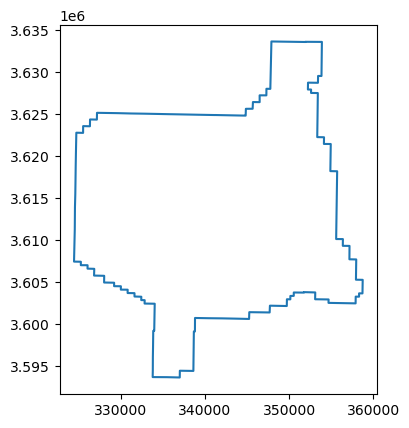

In [5]:
# Visualize the downloaded boundary.
bounds.boundary.plot()

We can see from the plotted map that the site is an irregular shape. For cases like this where the geometry is defined by many points, it is easiest to provide GeoCDL with a file containing the geometry definition, instead of uploading clipping coordinates. We can upload this geodataframe to GeoCDL using the `upload_geometry` function which returns a unique geometry upload identifier (GUID) that we will use later in our subset request. This stand-alone upload step is optional, but recommended if you are likely to submit multiple subset requests with the same geometry so that it is uploaded just once. You could alternatively use the `geopandas` GeoDataFrame object directly in requests instead of using a GUID, but if we upload the geometry file, then we can re-use the same GUID in subsequent requests.

Here, we upload our file by calling `upload_geometry()` on our `pygcdl_obj` object.

In [6]:
guid = pygcdl_obj.upload_geometry(bounds)
print(guid)

6072ed27-94e1-4ae1-b8d0-c3b3cf60a39a


To finish the spatial component of our subset request, we will define our target spatial resolution and a resampling method. By indicating a target spatial resolution along with our geometry, we are telling GeoCDL that we want a spatially-harmonized 'datacube', which means that each requested data layer has the same CRS, spatial resolution, and spatial extent. 

Unless we specify otherwise, the target CRS in this case is that of our geometry. Resampling is the process by which the GeoCDL calculates pixel values when the cell grid changes, like when we change the resolution or CRS. This calculation is performed by `rasterio`, and you can find the full list of reprojection methods [here](https://rasterio.readthedocs.io/en/stable/api/rasterio.enums.html#rasterio.enums.Resampling). The default resampling method is to take the nearest pixel's value. Here, we choose the "bilinear" method, which you can learn more about [here](https://gisgeography.com/bilinear-interpolation-resampling/).

Our CRS, EPSG:32613, is in units of meters. Therefore, our spatial resolution is in units of meters. Here, we specify that we want each pixel to represent an area of 1000 by 1000 meters.

In [ ]:
spat_res = 1000 # in units of meters
resample_method = "bilinear"

Next, we specify our temporal data. The GeoCDL accepts multiple temporal range formats so that many different user 
needs can be met. In this example, we are interested in July-August 2008. One way to specify that is with the years and months together as `dates='2008-07:2008-08'` or separately as below. By specifying years and months, we are letting GeoCDL know that we are interested in monthly data. If we only specify years, then it will infer we want annual data and if we also specifies days, then it will infer we want daily data. If the inferred date grain is supported by a dataset, then we use that grain for that dataset. If that date grain is not supported by a dataset, then GCDL uses the "grain method" variable, if set, to determine what other grains the user is willing accept. For example, here we specify "finer" to indicate that if monthly data is not available, we are also willing to accept daily data. Other options for grain methods include "strict", "skip", "any", and "coarser". 


In [ ]:
years = "2008"
months = "7:8"
grain_method = "finer"

## Part 2: Select datasets and their variables


We can use the `list_datasets()` function to list all of the datasets that are available in the Geospatial Common Data Library.

In [ ]:
pygcdl_obj.list_datasets()

We can use the `get_dataset_info()` function to learn more about one specific dataset.

In [ ]:
# Get information about the MODIS_NDVI dataset.
pygcdl_obj.get_dataset_info("MODIS_NDVI")

In [ ]:
# Get information about the PRISM dataset.
pygcdl_obj.get_dataset_info("PRISM")

Next, we will specify the datasets and variables we wish to use with a `pandas` dataframe. Here we specify that we want the 'ppt' variable from the PRISM dataset, and the 'NDVI' variable from the MODIS_NDVI dataset. We can format our dataset and variable specifications as a `pandas` dataframe, a numpy array, a matrix, or a dictionary. Here, we format our specifications as a `pandas` dataframe.

In [ ]:
dsvars = pd.DataFrame(
    [["PRISM", "ppt"], ["MODIS_NDVI", "NDVI"]], 
    columns=["dataset", "variable"])
print(dsvars)

## Part 3: Download the data

First, we create a directory where we would like our data to download to.

In [ ]:
output_path = Path("output")
if not output_path.is_dir():
    output_path.mkdir()

Up until now, we have been primarily saving our request specifications as variables. We will now pass each of those variables to the GeoCDL and download our subset using the `download_polygon_subset` function. GeoCDL returns a zipped folder of results and `pygcdl` unzips it for you. `download_polygon_subset` returns the filenames in that folder. We have here two monthly PRISM layers, seven daily MODIS NDVI layers (every 8 days), plus a metadata file that lists metadata related to the geospatial datasets as well as the GeoCDL request itself. The raster layer files are GeoTIFFs with the dataset, variable, and date indicated in the  filename.

In [ ]:
subset_files = pygcdl_obj.download_polygon_subset(
    dsvars=dsvars, 
    years=years,
    months=months,
    grain_method=grain_method,
    t_geom=guid,
    resolution=spat_res,
    dsn=output_path,
)

In [ ]:
subset_files

## Part 4: Visualize the results

Our use of `pygcdl` for this example is complete, but we can visualize the data that we downloaded. We can see that in our site, NDVI increased over July-August in 2008 but by different degrees within the site. 

#### MODIS_NDVI Visualization

In [ ]:
# Create a list of the NDVI GeoTIFFs.
modis_tifs = [k for k in subset_files if k.endswith('.tif') and "NDVI" in k]
print(modis_tifs)

In [ ]:
# Create a list of rioxarray datasets and count the images. Use the
# 'mask_and_scale=True' option to read nodata values as nan and to apply the
# scale factor.
modis_image_stack = [
    rioxarray.open_rasterio(k, mask_and_scale=True) for k in modis_tifs
]
num_images = len(modis_image_stack)
print(num_images)

In [ ]:
# Visualize the range of values of NDVI data in the first image.
modis_image_stack[0].plot.hist()

In [ ]:
# Extract the dates from the filenames and use them to title the subplots.
ndvi_layer_names = [
    string.split("NDVI_NDVI_")[1].split(".tif")[0] for string in modis_tifs
]

# Plot the data.
fig, axs = plt.subplots(nrows=2, ncols=4, figsize = (18, 10), sharey=True)
fig.suptitle("NDVI Values in Jornada Experimental Range, July-August 2028", fontsize=25)
plt.subplots_adjust(hspace=0.4)
for i in range(num_images):
    im = modis_image_stack[i].plot(ax=axs[math.floor(i/4), i%4], add_colorbar=False)
    axs[math.floor(i/4), i%4].set_title(ndvi_layer_names[i], fontsize=20)
    axs[math.floor(i/4), i%4].tick_params(labelrotation=45)
axs[1,3].axis("off")
label_axis = fig.add_axes([0.79, 0.12, 0.05, 0.3])
cbar = fig.colorbar(im, cax=label_axis)
cbar.set_label(label="NDVI", fontsize=20)

#### PRISM Visualizaiton

In [ ]:
# Create a list of PRISM GeoTIFFs.
prism_tifs = [k for k in subset_files if ".tif" in k and "PRISM" in k]
print(prism_tifs)

In [ ]:
# Create a list of rioxarray datasets and count the images. Use the
# 'masked=True' option to read nodata values as nan. Otherwise, nodata values
# for this data are read in as -9999
prism_image_stack = [
    rioxarray.open_rasterio(k, masked=True) for k in prism_tifs
]
num_images = len(prism_image_stack)
print(num_images)

In [ ]:
print("Min", float(prism_image_stack[0].min()))
print("Max", float(prism_image_stack[0].max()))
print("Mean", float(prism_image_stack[0].mean()))

In [ ]:
prism_image_stack[0].plot.hist()

In [ ]:
# Extract the dates from the filenames and use them to title the subplots.
prism_layer_names = [
    string.split("PRISM_ppt_")[1].split(".tif")[0] for string in prism_tifs
]

# Plot the data.
fig, axs = plt.subplots(ncols=2, figsize = (14, 8), sharey=True)
fig.suptitle("PRISM Values in Jornada Experimental Range, July-August 2028", fontsize=25)
plt.subplots_adjust(hspace=0.4)
for i in range(num_images):
    im = prism_image_stack[i].plot(ax=axs[i], add_colorbar=False)
    axs[i].set_title(ndvi_layer_names[i], fontsize=20)
    axs[i].tick_params(labelrotation=45)
fig.colorbar(im)